# imports

In [2]:
%matplotlib widget
import os
from datetime import datetime
from pathlib import Path  #to get user directory
from IPython.display import clear_output
#importa las fuciones que cree desde otro notebook (instalar modulo ipynb)
import ipynb.fs.full.my_funcs_clusters as myfunc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import font_manager
import matplotlib
matplotlib.use('Agg')

In [3]:
import importlib
importlib.reload(myfunc)

<module 'ipynb.fs.full.my_funcs_clusters' (C:\Users\mungu\Documents\GitHub\aero\my_funcs_clusters.ipynb)>

# Functions

In [4]:
def daymin2date(year,day,hour_min):
    """

    :param year: year when data was measured
    :param day: day
    :param hour_min: hour and minute in 24 hour format without separating character, e.g. 16:37 --> 1637
    :return: timestamp in format dd/mm/YYYY HH:MM
    """
    hourmin =hour_min.zfill(4)
    hour = hourmin[:2]
    minute = hourmin[2:]
    res = datetime.strptime(year + "-" + day +" "+hour +":"+minute, "%Y-%j %H:%M").strftime("%d/%m/%Y %H:%M")
    return res



## cluster2dataframe

In [5]:
'''TO DO: en el idx_centroids los numeros de los clusters no llevan la C, en el idx_centroids_sc si
la llevan, o cambiar todo a que la lleven o que no la lleven'''

from sklearn import cluster
from scipy.spatial.distance import cdist
#crear dataframes a partir de clusters
#def cluster2DataFrame(dfvxvy, dfVP, n_clusters, labels, n_subclu=0, clusters='viento',subclusters='viento'):
def cluster_to_dataframe(dfvxvy, n_clusters,dfVP = None, n_subclu=0, clusters='viento',subclusters='viento',datadir=None):
    """
        Description:
        Esta funcion toma diferentes dataframes de entrada agrupa los datos por cluster.
        :param clusters: first clustering
        :param subclusters: second clustering
        :param datadir:
        :param dfvxvy: dataframe con columnas vx y vy
        :param dfVP: dataframe con columnas de magnitud de viento y potencia
        :param n_clusters: numero de clusters
        :param n_subclu: Número de suclusters a calcular a partir de los n clusters calculados en un principio.
                  Si n_subclu=0 no se calcula ningun subcluster. Por defecto n_sub=0


        :return cl_ord: un array que contiene el número de cluster n ordenado de menor a mayor
            de las magnitudes de la velocidad de viento sin tomar en cuenta la direccion
        :return dfclvv: dataframe donde las componentes de velocidad de viento vx y vy estan
            agrupadas por cluster
        :return dfclpw: dataframe donde la potencia esta agrupada por cluster
        :return dfclvp: dataframe donde la potencia y la magnitud de viento esta agrupada por
            cluster
    """
    #'''- KMEANS -----------------------------------------------------------------------------------------'''
    if clusters=='viento':
        kmeans = cluster.KMeans(n_clusters=n_clusters,random_state=0).fit(dfvxvy)
        cl_centroids = kmeans.cluster_centers_
        cl_labels=kmeans.labels_
        clusassign=cl_labels#si nos e usa untrained data
        ncentroids = len(cl_centroids)
        #buscar centroides en dataframes
        #https://stackoverflow.com/questions/42583995/get-the-centroid-row-index-from-k-means-clustering-using-sklearn
        #clusassign = kmeans.fit_predict(dfvxvy.values)#solo se si utiliza untrained data
        #distancia minima a cada centroide
        min_dist = np.min(cdist(dfvxvy.values, kmeans.cluster_centers_, 'euclidean'), axis=1)
        Y = pd.DataFrame(min_dist, index=dfvxvy.index, columns=['PCTimeStamp'])
        Z = pd.DataFrame(clusassign, index=dfvxvy.index, columns=['cluster_ID'])
        #crea el dataframe
        PAP = pd.concat([Y,Z], axis=1)

    elif clusters=='potencia':

        kmeans = cluster.KMeans(n_clusters=n_clusters,random_state=0).fit(dfVP)
        cl_centroids = kmeans.cluster_centers_
        cl_labels=kmeans.labels_
        ncentroids = len(cl_centroids)
        #clusassign=cl_labels
        #buscar centroides en dataframes
        clusassign = kmeans.fit_predict(dfVP.values)
        min_dist = np.min(cdist(dfVP.values, kmeans.cluster_centers_, 'euclidean'), axis=1)
        Y = pd.DataFrame(min_dist, index=dfVP.index, columns=['PCTimeStamp'])
        Z = pd.DataFrame(clusassign, index=dfVP.index, columns=['cluster_ID'])
        PAP = pd.concat([Y,Z], axis=1)
    elif clusters=='direccion':
        kmeans = cluster.KMeans(n_clusters=n_clusters,random_state=0).fit(datadir)
        cl_centroids = kmeans.cluster_centers_
        cl_labels=kmeans.labels_
        #clusassign=cl_labels
        ncentroids = len(cl_centroids)
        #buscar centroides en dataframes
        clusassign = kmeans.fit_predict(dfVP.values)
        min_dist = np.min(cdist(dfVP.values, kmeans.cluster_centers_, 'euclidean'), axis=1)
        Y = pd.DataFrame(min_dist, index=dfVP.index, columns=['PCTimeStamp'])
        Z = pd.DataFrame(clusassign, index=dfVP.index, columns=['cluster_ID'])
        PAP = pd.concat([Y,Z], axis=1)

    #ordend e los cluster por magnitud de vv
    cl_magni = np.zeros(n_clusters)
    for i in range(n_clusters):
        vx = dfvxvy.vx.values[cl_labels == i]
        vy = dfvxvy.vy.values[cl_labels == i]
        cl_magni[i] = np.mean(np.sqrt(vx**2 + vy**2))  #magnitud de la vv
    cl_ord = np.argsort(cl_magni.argsort()) #ver https://github.com/numpy/numpy/issues/8757




    grouped = PAP.groupby(['cluster_ID'])#agrupa por numero de clusters las distancias minimas
    idx_centroids = grouped.idxmin()#encuentra el indice de la distanciam minima
    #agregando columnas de velocidadd de viento y potencia al dataframe de los centroides
    vxvy=dfvxvy.loc[idx_centroids.PCTimeStamp].values
    if dfVP:
        vvpot = dfVP.loc[idx_centroids.PCTimeStamp].values

        idx_centroids=idx_centroids.assign(vx=vxvy[:,0],vy=vxvy[:,1],vViento=vvpot[:,0],Pw=vvpot[:,1])
        idx_centroids.sort_values(by='vViento',inplace=True)# ordenar por velocidad de viento
        idx_centroids.reset_index(inplace=True) #que ya no sea el cluster id el indice
        idx_centroids.index.set_names('cluster_ID_ord',inplace=True)  #ponerle el nombre al indice ordenado
        idx_centroids.index+=1 #paraque el indice empieze en uno y no exista cluster 0
    if clusters=='direccion':
        print('not implement yet')
        #SUSTITUIR CENTROIDS DE DIRECCION POR VELOCIDAD
        #lc =[]

        #for labcl in np.unique(cl_labels):

         #   lc.append(centroidpython(dfvxvy.values[cl_labels==labcl]))

        #cl_centroids=np.array([[i[0],i[1]]for i in cl_centroids])
        #ordenar centroides
        #cl_cenroids=cl_centroids[cl_centroids[:,0].argsort()]



    ## ######################## CREAR MULTIINDICE ########################'''
    #CLUSTER VX,VY:
    #https://stackoverflow.com/questions/37835508/how-to-do-multi-column-from-tuples
    #nombre de las columnas del dataframe
    colheadvv = []
    colheadpw = []
    for i in range(n_clusters):
        colheadvv.append(('C' + str(i + 1), 'vx'))
        colheadvv.append(('C' + str(i + 1), 'vy'))
        colheadpw.append('C' + str(i + 1))
    dfclvv = pd.DataFrame()
    for i in range(n_clusters):
        a = dfvxvy.vx[cl_labels ==np.where(cl_ord ==i)[0][0]].reset_index().drop(['timeStamp'],axis=1)
        b = dfvxvy.vy[cl_labels == np.where(cl_ord ==i)[0][0]].reset_index().drop(['timeStamp'],axis=1)
        dfclvv = pd.concat([
            dfclvv, a,b
        ],
            axis=1,
            ignore_index=True)
    #crear multiindice
    dfclvv.columns = pd.MultiIndex.from_tuples(colheadvv)

    #CLUSTER POTENCIA:
    if dfVP:
        dfclpw = pd.DataFrame()
        for i in range(n_clusters):
            dfclpw = pd.concat([dfclpw, dfVP.Pw[cl_labels == np.where(cl_ord ==i)[0][0]]],
                               ignore_index=True,
                               axis=1)
        dfclpw.columns = colheadpw

        #CLUSTER VIENTO POTENCIA:
        colheadvp = []
        for i in range(n_clusters):
            colheadvp.append(('C' + str(i + 1), 'vViento'))
            colheadvp.append(('C' + str(i + 1), 'Pw'))
        dfclvp = pd.DataFrame()
        for i in range(n_clusters):
            dfclvp = pd.concat([
                dfclvp, dfVP.vViento[cl_labels == np.where(cl_ord ==i)[0][0]],
                dfVP.Pw[cl_labels ==np.where(cl_ord ==i)[0][0]]] ,
                axis=1,
                ignore_index=True)
        #crear multiindice
        dfclvp.columns = pd.MultiIndex.from_tuples(colheadvp)

    if clusters=='direccion':
        #CLUSTER direccion viento
        colheadvp = []
        for i in range(n_clusters):
            colheadvp.append(('C' + str(i + 1), 'Dir'))
            colheadvp.append(('C' + str(i + 1), 'vViento'))
        dfcldv = pd.DataFrame()
        for i in range(n_clusters):
            dfcldv = pd.concat([
                dfcldv, datadir.vViento[cl_labels ==( cl_ord ==i)],
                datadir.Dir[cl_labels == (cl_ord ==i)]],
                axis=1,ignore_index=True)
        #crear multiindice
        dfcldv.columns = pd.MultiIndex.from_tuples(colheadvp)
    '''- CALCULAR SUBCLUSTERS ------------------------------------------------------------------- '''


    if n_subclu > 0 and dfVP:
        scl_centroids = []
        scl_labels = []
        scl_ncentroids =[]
        idx_centroids_sc= pd.DataFrame() #va almacenar los centroides de los subclusters
        #obtener los resultados del clusterizado
        for i in range(n_clusters):
            if subclusters=='viento':
                dfclvvnoNA=dfclvv['C'+str(i+1)].dropna()
                #buscando centroides con los subclusters
                kmeans_sc = cluster.KMeans(n_clusters=n_subclu, random_state=0).fit(dfclvvnoNA)
                min_dist_sc = np.min(cdist(dfclvvnoNA.values, kmeans_sc.cluster_centers_, 'euclidean'), axis=1)
                Y_sc = pd.DataFrame(min_dist_sc, index=dfclvvnoNA.index, columns=['PCTimeStamp'])
                Z_sc = pd.DataFrame(kmeans_sc.labels_, index=dfclvvnoNA.index, columns=['subcluster_ID'])

            elif subclusters=='potencia':
                dfclvpnoNA=dfclvp['C'+str(i+1)].dropna()
                #buscando centroides con los subclusters
                kmeans_sc = cluster.KMeans(n_clusters=n_subclu, random_state=0).fit(dfclvpnoNA)
                min_dist_sc = np.min(cdist(dfclvpnoNA.values, kmeans_sc.cluster_centers_, 'euclidean'), axis=1)
                Y_sc = pd.DataFrame(min_dist_sc, index=dfclvpnoNA.index, columns=['PCTimeStamp'])
                Z_sc = pd.DataFrame(kmeans_sc.labels_, index=dfclvpnoNA.index, columns=['subcluster_ID'])
            else:
                print('Todavía no programado, haciendo subclusters en potencia')
                kmeans_sc = cluster.KMeans(n_clusters=n_subclu, random_state=0).fit(dfclvp['C'+str(i+1)].dropna())

            scl_centroids.append(kmeans_sc.cluster_centers_)
            scl_labels.append(kmeans_sc.labels_)
            scl_ncentroids.append(len(scl_centroids[i]))


            PAP_sc = pd.concat([Y_sc,Z_sc], axis=1)
            #poniendo index a los centroides de los subclusters
            grouped_sc = PAP_sc.groupby(['subcluster_ID'])
            idx_cent_sc = grouped_sc.idxmin()
            idx_cent_sc.index +=1
            #agregando columnas de velocidadd de viento y potencia al dataframe de los centroides
            vxvy_sc=dfvxvy.loc[idx_cent_sc.PCTimeStamp].values
            vvpot_sc = dfVP.loc[idx_cent_sc.PCTimeStamp].values
            idx_centroids_sc=pd.concat([idx_centroids_sc, idx_cent_sc.assign(vx=vxvy_sc[:,0],vy=vxvy_sc[:,1],
                                                                             vViento=vvpot_sc[:,0], Pw=vvpot_sc[:,1], cluster_ID='C'+str(i+1))] )
        #creando el multiindex fuera del ciclo for
        # idx_centroids_sc.set_index(['cluster_ID',idx_centroids_sc.index],inplace=True)

        idx_centroids_sc.reset_index(inplace=True)
        idx_centroids_sc.sort_values(['cluster_ID','vViento'], ascending=[1,1],inplace=True)
        lst_num_sc=list(range(1,n_subclu+1))*n_clusters#crea una lista de numeros para el subcluster [1,2,3..1,2,3]
        sc_idx_list =list(map(lambda x:'SC'+str(x),lst_num_sc))#le pone las letras SC [SC1,SC2,SC3...SC1,SC2,SC3]
        idx_centroids_sc=idx_centroids_sc.assign(subcluster_ID_ord=sc_idx_list)
        idx_centroids_sc.set_index(['cluster_ID','subcluster_ID_ord'],inplace=True)


        ############  ORDENAR CENTROIDES:  ordenar el orden de aparicion segun la magnitud de la vv
        scl_magni = np.zeros([n_clusters,n_subclu])
        scl_ord = []

        for i in range(n_clusters):

            for j in range(n_subclu):

                vx = dfclvv['C' + str(i+1)].vx.dropna().values[scl_labels[i] == j]
                vy = dfclvv['C' + str(i+1)].vy.dropna().values[scl_labels[i] == j]
                scl_magni[i][j] = np.mean(np.sqrt(vx**2 + vy**2))  #magnitud de la vv

            scl_ord.append( scl_magni[i].argsort())# ver https://github.com/numpy/numpy/issues/8757

        #ORDENAR CENTROIDES
        for i in range(len(scl_centroids)):
            scl_centroids[i] = scl_centroids[i][scl_ord[i]]



            #CLUSTER VIENTO POTENCIA:
        colheadvp = []
        for i in range(n_clusters):
            for j in range(n_subclu):
                colheadvp.append(('C' + str(i + 1),'SC' + str(j + 1), 'vViento'))
                colheadvp.append(('C' + str(i + 1),'SC' + str(j + 1), 'Pw'))
        dfsclvp = pd.DataFrame()

        for i in range(n_clusters):
            for j in range(n_subclu):
                dfsclvp = pd.concat([
                    dfsclvp, dfclvp['C'+str(i+1)].dropna().vViento[scl_labels[i]  == scl_ord[i][j]],
                    dfclvp['C'+str(i+1)].dropna().Pw[scl_labels[i] == scl_ord[i][j]]
                ],
                    axis=1,
                    ignore_index=True)
        #crear multiindice
        dfsclvp.columns = pd.MultiIndex.from_tuples(colheadvp)

        #CLUSTER VX,VY:####################################################
        colheadvv = []
        for i in range(n_clusters):
            for j in range(n_subclu):
                colheadvv.append(('C' + str(i + 1),'SC' + str(j + 1), 'vx'))
                colheadvv.append(('C' + str(i + 1),'SC' + str(j + 1), 'vy'))
        dfsclvv = pd.DataFrame()

        for i in range(n_clusters):
            for j in range(n_subclu):
                dfsclvv = pd.concat([
                    dfsclvv, dfclvv['C'+str(i+1)].dropna().vx[scl_labels[i]  == scl_ord[i][j]],
                    dfclvv['C'+str(i+1)].dropna().vy[scl_labels[i] == scl_ord[i][j]]
                ],
                    axis=1,
                    ignore_index=True)
        #crear multiindice
        dfsclvv.columns = pd.MultiIndex.from_tuples(colheadvv)

        #CLUSTER POTENCIA:
        dfsclpw = pd.DataFrame()
        colheadpw =[]
        for i in range(n_clusters):
            for j in range(n_subclu):
                colheadpw.append(('C' + str(i + 1),'SC' + str(j + 1)))

        for i in range(n_clusters):
            for j in range(n_subclu):
                dfsclpw = pd.concat([dfsclpw, dfclvp['C'+str(i+1)].Pw.dropna()[scl_labels[i] == scl_ord[i][j]]],
                                    ignore_index=True,
                                    axis=1)
        dfsclpw.columns = pd.MultiIndex.from_tuples(colheadpw)

        #### buscar centroides para la grafica vv
        #obtener nombre de niveles
        #n_subclu = len(dfsclvv.columns.levels[1])
        #numero total de clusters incluidos los subclusters
        #n_tot_clusters = n_subclu*n_clusters
        # solo aplica cuando hay subclusters
        #lev0 = dfsclvv.columns.get_level_values(0)
        #lev1 = dfsclvv.columns.get_level_values(1)
        #namcl = [(lev0[i],lev1[i]) for i in range(len(lev0))]
        #colnames = namcl[::2]


        '''TODO: QUE EL RETURN TENGA ESTA FUNCIONALIDAD'''
        #return  dfsclvv,dfsclpw,dfsclvp,cl_ord,cl_centroids, idx_centroids,scl_ord,scl_centroids,idx_scl_centroids
        if clusters=='direccion':
            return  dfsclvv,dfsclpw,dfsclvp,dfclvp,cl_ord,cl_centroids, idx_centroids,scl_ord,scl_centroids,

        else:
            return  dfsclvv,dfsclpw,dfsclvp,cl_ord,cl_centroids, idx_centroids,scl_ord,scl_centroids,idx_centroids_sc

    else:# sin subclusters
        if dfVP: #con potencia
            if clusters=='direccion':
                print('NO PROGRAMADO')
                return dfclvv, dfclpw, dfclvp,dfcldv,cl_ord, cl_centroids,idx_centroids
            else:
                scl_ord=[]
                scl_centroids=[]
                idx_centroids_sc=[]
                return dfclvv,dfclpw,dfclvp,cl_ord,cl_centroids,idx_centroids,scl_ord,scl_centroids,idx_centroids_sc

        if clusters=='direccion':
            print('NO PROGRAMADO')
            return dfclvv, None, None,dfcldv,cl_ord, cl_centroids,idx_centroids
        else:
            scl_ord=[]
            scl_centroids=[]
            idx_centroids_sc=[]
            return dfclvv,None,None,cl_ord,cl_centroids,idx_centroids,scl_ord,scl_centroids,idx_centroids_sc


# data processing

In [6]:
###########################################configuración
columns_to_use = [0,1,3,6]
columns_id =['day','hour','wdir','vwind']
home = str(Path.home()) #user directory
xlsPath = home + '\\Dropbox\\Doctorado\\Documentos\\datos\\datos bcs\\DP-PB01-2005.xlsx'
xlsPathMfgCurve = home + '\\Dropbox\\Doctorado\\Python\\aero\\Curva de potencia vestas 90.xlsx'
dir_format= 'deg'
year = '2005' #data year
########################################################
#imprimir a consola
os.write(1, b"Inciando procesamiento de datos...\n")

dataVDxls = pd.read_excel(xlsPath,usecols=columns_to_use,dtype={'DIA' : str, 'HORA':str})
dataVDxls.columns =columns_id
#agrego la columna de potencia instantanea sin filtrar
#dataVPxls['Pw']= (dataVPxls.iloc[1:,1].values-dataVPxls.iloc[0:-1,1]) * np.pi*45**2
print('Total de registros: ' + str(len(dataVDxls)))
#dfMfgCurve = pd.read_excel(xlsPathMfgCurve,usecols=[0,2],index_col=0,names=['pw'])#cambio esto en la nueva version
dfMfgCurve = pd.read_excel(xlsPathMfgCurve,usecols=[0,2],index_col=0)
dfMfgCurve.columns = ['pw']
#marcando los datos faltantes asignando un nan a la fila completa
datamk = dataVDxls
datamk.loc[datamk.isnull().any(axis=1), :] = np.nan
#numero de filas sin datos
print('Numero de filas sin datos')
print(datamk.loc[datamk.isnull().any(axis=1), :].isnull().sum())

#eliminando filas con NaN
cleanData = datamk.dropna()


#datos direccion velocidad
#print(len(dataVP))
#print(len(dataDir))
#dataDV = pd.concat([dataDir,dataVP.vViento],axis=1)
#dataVD = pd.concat([dataVP.vViento,dataDir,axis=1)
#dataVcD =pd.concat([dataDir,df_comp_vel],axis=1)
#change hour 24:00 to 00:00
dataVDxls['hour']=dataVDxls['hour'].str.replace('2400','0000')
dataVDxls['timeStamp']= dataVDxls.apply(lambda x: myfunc.daymin2date(year,x.day, x.hour), axis=1)
dataVDxls.set_index('timeStamp',inplace=True,verify_integrity = True)
dfWD = dataVDxls.drop(columns=['day','hour'])
dfWD.index = pd.to_datetime(pd.to_datetime(dfWD.index).strftime('%d/%m/%Y %H:%M'))

del(dataVDxls)
#CHECK THE DIRECTION OF THE ANEMOMETER
if dir_format == 'rad':
    direcvrad= np.deg2rad(dfWD['wdir'].values)
    vecVel = [-np.sin(direcvrad)*dfWD['vwind'].values,np.cos(direcvrad)*dfWD['vwind'].values]
else:
    vecVel = [-np.sin(dfWD['wdir'].values * np.pi / 180) * dfWD['vwind'].values,
              np.cos(dfWD['wdir'].values * np.pi / 180)* dfWD['vwind'].values]


vecVelnp = np.array(vecVel).transpose()
#original sin timestamp
#df_comp_vel = pd.DataFrame(data=vecVelnp,columns=['vx','vy']
#con timestamp
df_comp_vel = pd.DataFrame(data=vecVelnp,columns=['vx','vy'],index=dfWD.index)


os.write(1, b"Fin del procesamiento de datos\n")
print('Fin del procesamiento de datos')

Total de registros: 52560
Numero de filas sin datos
day      0.0
hour     0.0
wdir     0.0
vwind    0.0
dtype: float64
Fin del procesamiento de datos


# Test

## Serie de tiempo

In [7]:
dfWD.vwind.plot(figsize=(20,10))

<AxesSubplot:xlabel='timeStamp'>

C:\Users\mungu\AppData\Local\Temp/ipykernel_26680/1673444538.py:94: UserWarning: shading value 'gourad' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  axDensity.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gourad', cmap=plt.cm.inferno)


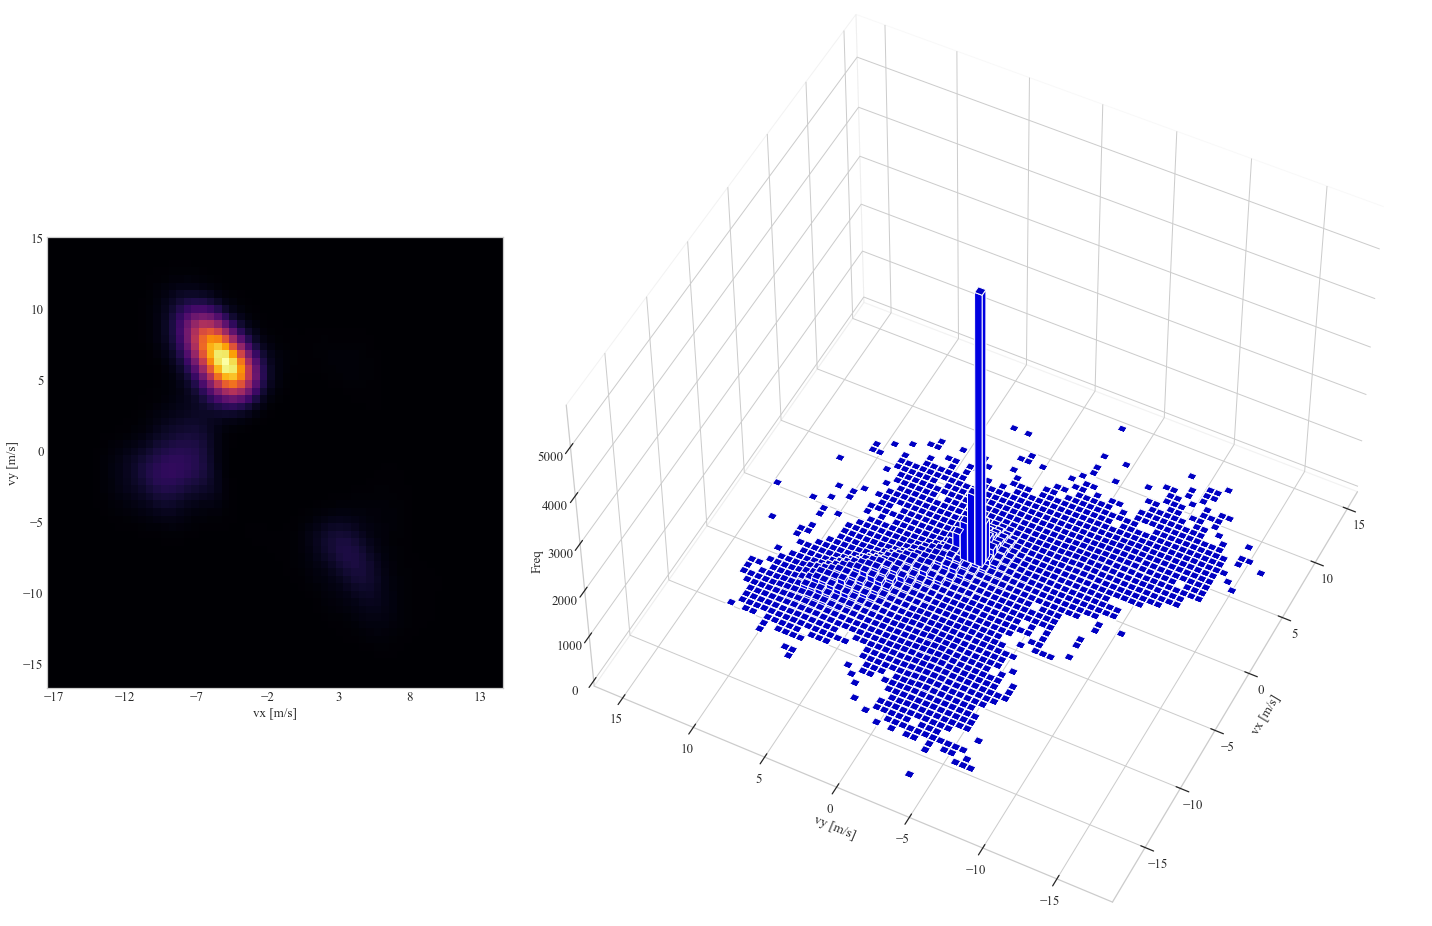

In [8]:
fontsize = 13
labelFontSize = 13
tickFontSize = 12
markerSize = 100
fontNameLabel = {'fontname':'Times New Roman'}
fontNameCluster = {'fontname':'Arial'}
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal',
                                         size=labelFontSize, weight='normal', stretch='normal')
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal',
                                         size=labelFontSize, weight='normal', stretch='normal')
#en esta celda se usa gridspec para cambiar el tamaño de subplots individuales
%matplotlib inline
from scipy.stats import kde

pltfstitle =10 #tamaño de fuente
pltfslbl =13
nbins =60

H, xedges, yedges = np.histogram2d(df_comp_vel.vx.values, df_comp_vel.vy.values,bins=nbins )
H=H.T;
#
# Create an X-Y mesh of the same dimension as the 2D data. You can
# think of this as the floor of the plot.
#

x_data, y_data = np.meshgrid( xedges[:-1],yedges[:-1])
# Flatten out the arrays so that they may be passed to "ax.bar3d".
# Basically, ax.bar3d expects three one-dimensional arrays:
# x_data, y_data, z_data. The following call boils down to picking
# one entry from each array and plotting a bar to from
# (x_data[i], y_data[i], 0) to (x_data[i], y_data[i], z_data[i]).
#
x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = H.flatten()

# Create a figure for plotting the data as a 3D histogram.
#
fig = plt.figure(figsize=(20,14))

# eliminar elementos con frecuencia zero
a = z_data[z_data != 0]
idx=np.where(z_data == 0)[0]
b=np.delete(x_data,idx)
c=np.delete(y_data,idx)
z_data=a
x_data=b
y_data=c

# tres graficas
#cmap del histograma2d. Es un array de nx 4 elementos (rgba)
#histograma 3d
#ax = fig.add_subplot(121, projection='3d')
#grid = plt.GridSpec(2,2, wspace=0.3, hspace=0.1)
#axScatter=fig.add_subplot(grid[0, 0])
#axDensity= fig.add_subplot(grid[0, 1])
#axHist2d =fig.add_subplot(grid[1,0: ], projection='3d')

# dos graficas
#cmap del histograma2d. Es un array de nx 4 elementos (rgba)
#histograma 3d
#ax = fig.add_subplot(121, projection='3d')
grid = plt.GridSpec(1, 2, width_ratios=[1, 2])

#grid = plt.GridSpec(1,2, wspace=0.3, hspace=0.1)
#axScatter=fig.add_subplot(grid[0, 0])
axDensity= fig.add_subplot(grid[0, 0])
axHist2d =fig.add_subplot(grid[0,1 ], projection='3d')

#SCATTER
#axScatter.scatter(df_comp_vel.vx,df_comp_vel.vy,s=0.6)
#axScatter.set_ylabel('vy [m/s]', fontsize = pltfslbl)
#axScatter.set_xlabel('vx [m/s]', fontsize = pltfslbl)
##axScatter.set_aspect('equal')
#axScatter.set_xticks(np.arange(np.around(df_comp_vel.vx.min()),df_comp_vel.vx.max(),5))

#DENSITY PLOT

data = np.array(df_comp_vel[dfWD.vwind>6].values.tolist())
x, y = data.T
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

axDensity.set_ylabel('vy [m/s]', fontsize = pltfslbl,fontname='Times New Roman')
axDensity.set_xlabel('vx [m/s]', fontsize = pltfslbl,fontname='Times New Roman')
axDensity.tick_params(axis='both', labelsize = pltfslbl)
axDensity.set_aspect('equal')
axDensity.set_xticks(np.arange(np.around(df_comp_vel.vx.min()),df_comp_vel.vx.max(),5))


#guardo el objeto pcolormesh para obtener su cmap
axDensity.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gourad', cmap=plt.cm.inferno)

#HIST2D

axHist2d.tick_params(axis='both', labelsize = pltfslbl)
ancho_barra =0.5
largo_barra = 0.5
axHist2d.bar3d( x_data,
                y_data,
                np.zeros_like(z_data),
                ancho_barra, largo_barra, z_data, shade=True,
                color = 'blue')
axHist2d.xaxis.pane.fill = False
axHist2d.yaxis.pane.fill = False
axHist2d.zaxis.pane.fill = False
axHist2d.set_aspect('auto')

#Vista del histograma 3d
axHist2d.view_init(50,-153)
axHist2d.set_ylabel('vy [m/s]', fontsize = pltfslbl,fontname='Times New Roman')
axHist2d.set_xlabel('vx [m/s]', fontsize = pltfslbl,fontname='Times New Roman')
axHist2d.set_zlabel('Freq', fontsize = pltfslbl, rotation= 90,fontname='Times New Roman')

for label in axDensity.get_xticklabels():
    label.set_fontproperties(ticks_font)
for label in axDensity.get_yticklabels():
    label.set_fontproperties(ticks_font)

for label in axHist2d.get_xticklabels():
    label.set_fontproperties(ticks_font)
for label in axHist2d.get_yticklabels():
    label.set_fontproperties(ticks_font)
for label in axHist2d.get_zticklabels():
    label.set_fontproperties(ticks_font)

plt.tight_layout()




#figsavetime = datetime.datetime.now().strftime("%d-%m-%Y_%H_%M_%S_%f")
#plt.savefig('fig_art/pdf_hist2d_'+ figsavetime +'.png', bbox_inches='tight', pad_inches=0.1)


plt.show()

# Clusters

In [9]:
import importlib
importlib.reload(myfunc)

<module 'ipynb.fs.full.my_funcs_clusters' (C:\Users\mungu\Documents\GitHub\aero\my_funcs_clusters.ipynb)>

In [10]:
#n_clusters=15
#dfclvv, dfclpw, dfclvp, cl_ord,cl_cent,idx_centroids,scl_ord,scl_cent,idx_centroids_sc = myfunc.dataframe_to_cluster
# (df_comp_vel, n_clusters=n_clusters, clusters_data='wind')

n_clusters = 15
clusters_wind = myfunc.KMData()
clusters_wind.dataframe_to_cluster(df_comp_vel, n_clusters=n_clusters, clusters_data='wind')
#crear un dataframe viento, direccion, cluster
df_wind_dir_cl = dfWD.copy()
#tomando las labels de kmeans y sumandole uno por que empieza en 0
#ademas agregando la letra C y ordenando de menor v a mayor vel
col_clnames = ['C' + str(clusters_wind.cl_ord[c]+1) for c in clusters_wind.kmeans_labels]
df_wind_dir_cl['cluster'] = col_clnames
del col_clnames


In [11]:
for i in range(len(clusters_wind.idx_centroids)):
    print(np.sqrt( (clusters_wind.idx_centroids.vx.values[i])**2 +
                   (clusters_wind.idx_centroids.vy.values[i])**2))

4.167
8.87
0.102
10.26
2.261
6.751
4.244
11.1
11.21
7.53
7.32
6.346
1.934
5.967
2.869


## Plot

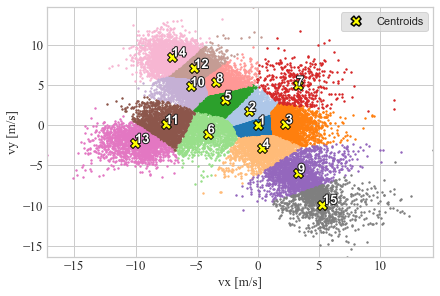

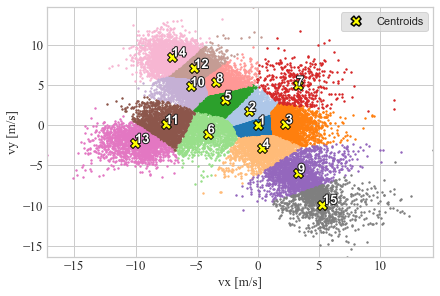

In [12]:
""'''
TODO:
    -que de una opción de mostrar solo viento o potencia aunque tenga subclusters
    -que funcione si solo incluyo dfclvv aunque tenga subclusters

'''
import matplotlib.pyplot as plt
from matplotlib.widgets import RadioButtons, TextBox
from IPython.display import display as wgdisplay
import ipywidgets as widgets
from ipywidgets import Layout
from ipywidgets import interact, interactive, fixed, interact_manual
import datetime
from matplotlib.ticker import EngFormatter
import matplotlib.patheffects as path_effects #efectos de texto
from matplotlib import font_manager
import matplotlib.lines as mlines
import seaborn as sns

sns.set()
plt.style.use('seaborn-white')
sns.set_style("whitegrid")

class PlotSubClusterInt:
    """
    Descripcion:
    Clase para dibujar dos subplots, uno vx vs vy y otro vviento vs Pw.

    Metodos:
        createPlot: Construye el plot de matplotlib.
            self.dfclvv: dataframe multiindice con dos columnas vx y vy agrupadas por cluster
            dfclpw: dataframe multiindice con dos columnas vviento y Pw agrupadas por cluster
            cl_method: string que almacena el metodo usado para hacer el cluster
                     |   C1    |   C2   |...
                    ----------------------
            Timestamp|  vx vy  |  vx vy |...            datavp: dataframe original de los datos de

        updatePlot: actuliza el plot en "tiempo real" segun los valores de los controles

        onClick: Es el la funcion que esta ligada al click en el plot. Solo ejecuta annotatePlot.

        annotatePlot: Crea una anotacion en el plot que indica donde el nombre del cluster mas cercano al conjunto de
              coordenadas donde se hizo click en el plot VP. Ademas muestra el cluster en el plot VV.

        blinkCluster: Resalta el cluster al que se hace referencia.

    Argumentos:
        cl_scl_order: el orden en que se hicieron los clusters (viento,viento), (viento,potencia),
            (potencia,viento),(potencia,potencia)
    """

    def __init__(self):
        self.axvp = None
        self.formatterPw = None
        self.fig = None
        self.axvv = None
        self.tbFilePath = None
        self.wchkcls = None
        self.tbreta = None
        self.wradText = None
        self.chkShowCPotFab = None
        self.chkShowBetz = None
        self.chkLimGlob = None
        self.chkShowCnt = None
        self.wdgPSize = None
        self.btnSelNoneChk = None
        self.btnSelAllChk = None
        self.btnUpdate = None
        self.vxmaxGlob = None
        self.pmaxGlob = None
        self.vvmaxGlob = None
        self.vvminGlob = None
        self.pminGlob = None
        self.vymaxGlob = None
        self.vyminGlob = None
        self.vxminGlob = None
        self.cl_avail = None
        self.clnames_all = None
        self.n_tot_clusters = None
        self.idx_centroids_sc = None
        self.idx_centroids = None
        self.dfclvp = None
        self.n_clusters = None
        self.showLegends = None
        self.savepath = None
        self.showlBetz = None
        self.showCent = None
        self.showMfgCurve = None
        self.showOpts = None
        self.vvento = None
        self.PMaxViento = None
        self.cl_scl_order = None
        from colorsys import hls_to_rgb
        self.fignum=999
        self.fisize = (5, 5)
        self.fontsize = 13
        self.labelFontSize = 13
        self.tickFontSize = 12
        self.markerSize = 100
        self.fontNameLabel = {'fontname':'Times New Roman'}
        self.fontNameCluster = {'fontname':'Arial'}
        self.ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal',
                                                      size=self.labelFontSize, weight='normal', stretch='normal')
        self.n_subclu = 0
        colors1 = plt.cm.tab20(np.linspace(0., 1, 20))
        colors2 = plt.cm.Spectral(np.linspace(0, 1, 10))
        colorstab = np.vstack((colors1, colors2))
        self.mapa_colores=colorstab
        self.fisize = None
        self.dfclvv = None
        self.datavp = None
        self.dfMfgCurve=None
        self.dfclvp_is_empty = True


    def create_plot(self, dfclvv, dfclvp=None,datavp=None,figsize=(5, 5), cl_scl_order=(None, None),
                    idx_centroids=None,idx_centroids_sc=None,fign=999, savepath='', showCent =True,
                    showlBetz = False,showMfgCurve=False, showOpt = 'Magnitud',dfMfgCurve=None,
                    showLegends = True):
        """

        :param dfclvv:
        :param dfclvp:
        :param datavp:
        :param figsize:
        :param cl_scl_order:
        :param idx_centroids:
        :param idx_centroids_sc:
        :param fign:
        :param savepath:
        :param showCent:
        :param showlBetz:
        :param showMfgCurve:
        :param showOpt:
        :param dfMfgCurve:
        :param showLegends:
        """
        self.dfMfgCurve=dfMfgCurve
        if self.dfMfgCurve is None:
            os.write(1,b'Manufacturer power curve missing')
        self.showLegends = showLegends
        self.cl_scl_order = cl_scl_order
        self.dfclvp =dfclvp
        self.dfclvv = dfclvv
        self.datavp = datavp
        self.n_clusters = len(self.dfclvv.columns.levels[0])
        self.n_tot_clusters =self.n_clusters
        self.fignum =fign
        self.idx_centroids =idx_centroids
        self.idx_centroids_sc= idx_centroids_sc
        self.savepath = savepath
        self.showlBetz = showlBetz # show Betz's limit
        self.showCent = showCent # show clusters centroids
        self.showMfgCurve = showMfgCurve #show manufacturer's curve
        #which value is shown in the plot magnitude,cluster number,cluster name, none
        self.showOpts = showOpt

        #check if power data was passed
        if self.dfclvp is not None:
            self.dfclvp_is_empty = False

        ##################################
        #        limite de betz          #
        ##################################
        if not self.dfclvp_is_empty:
            A=np.pi*45**2
            Cp = 0.59 #limite de Betz
            rho = 1.1349
            self.vvento = np.unique(datavp.vViento.values)
            self.PMaxViento = 1/2*rho*A*self.vvento**3*Cp

        #########################################
        #           CREAR PLOT                  #
        #########################################

        #para poner el plot dentro de un widget
        self.output = widgets.Output()
        plt.ioff()
        with self.output:
            self.fig = plt.figure(self.fignum, figsize=self.fisize,constrained_layout=True)
        #self.fig = plt.figure(self.fignum, figsize=self.fisize,constrained_layout=True)
        #1k, 1M
        self.formatterPw = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009
        # 3 because is cluster,subcluster,vx and vy
        if len(dfclvv.columns[0]) == 3:
            #last column has the last subcluster name SCn, this gives n
            self.n_subclu=int(dfclvv.columns[-1][1][2:])

        if not self.dfclvp_is_empty:
            self.axvv = self.fig.add_subplot(121)
            if self.n_subclu > 0:  # existen subclusters , sino seria 2
                #numero total de clusters incluidos los subclusters
                self.n_tot_clusters = self.n_subclu*self.n_clusters
                # solo aplica cuando hay subclusters
                lev0 = self.dfclvv.columns.get_level_values(0)
                lev1 = self.dfclvp.columns.get_level_values(1)
                namcl = [(lev0[i],lev1[i]) for i in range(len(lev0))]
                #self.clnames_all = sorted(namcl[::2]) #todos los clusters y subclusters disponibles
                self.clnames_all = namcl[::2] #todos los clusters y subclusters disponibles
                #ordenar
                vv = [self.idx_centroids_sc.loc[c].vViento for c in self.clnames_all]
                idx = np.argsort(vv)
                x=[self.clnames_all[i] for i in idx]
                self.clnames_all=x.copy()
                del x
                #nombre de los clusters disponibles sin el nombre de los subclusters
                #self.cl_avail =sorted(set(item[0] for item in self.clnames_all))
                self.cl_avail =set(item[0] for item in self.clnames_all)
                #### BUSCAR MINIMOS Y MAXIMOS GLOBALES  (hacerlo más elegante)
                l=[self.dfclvv[cl].min() for cl in self.clnames_all]
                self.vxminGlob,self.vyminGlob =   np.amin(l,axis=0)
                l=[self.dfclvv[cl].max() for cl in self.clnames_all]
                self.vxmaxGlob,self.vymaxGlob =   np.amax(l,axis=0)

            else:  # no hay subcluster
                #lista ordenada con numeros y letras
                self.clnames_all=sorted(dfclvv.columns.levels[0],
                                        key=lambda x: int("".join([i for i in x if i.isdigit()])))
                #self.cl_avail =sorted(set(item for item in self.clnames_all))
                self.cl_avail =set(item for item in self.clnames_all)
            l=[self.dfclvp[cl].min() for cl in self.clnames_all]
            self.vvminGlob,self.pminGlob =   np.amin(l,axis=0)
            l=[self.dfclvp[cl].max() for cl in self.clnames_all]
            self.vvmaxGlob,self.pmaxGlob =   np.amax(l,axis=0)
        else:
            self.axvv = self.fig.add_subplot()
            #lista ordenada con numeros y letras
            self.clnames_all=sorted(dfclvv.columns.levels[0],
                                    key=lambda x: int("".join([i for i in x if i.isdigit()])))
            #self.cl_avail =sorted(set(item for item in self.clnames_all))
            self.cl_avail =set(item for item in self.clnames_all)
            #### BUSCAR MINIMOS Y MAXIMOS GLOBALES  (hacerlo más elegante)
            l=[self.dfclvv[cl].min() for cl in self.clnames_all]
            self.vxminGlob,self.vyminGlob =   np.amin(l,axis=0)
            l=[self.dfclvv[cl].max() for cl in self.clnames_all]
            self.vxmaxGlob,self.vymaxGlob =   np.amax(l,axis=0)

        if not self.dfclvp_is_empty:
            self.axvp = self.fig.add_subplot(122)
            self.axvp.yaxis.set_major_formatter(self.formatterPw)



        ##############################################################################
        #                             WIDGETS                                        #
        ##############################################################################

        self.btnUpdate = widgets.Button(description='Actualizar')

        self.btnUpdate.on_click(self.update_plot)
        self.btnSelAllChk = widgets.Button(description='Sel. todo')
        self.btnSelAllChk.on_click(self.sel_all_chk)
        self.btnSelNoneChk = widgets.Button(description='Des. todo')
        self.btnSelNoneChk.on_click(self.sel_none_chk)
        self.wdgPSize = widgets.IntSlider(
            value=2,
            min=1,
            max=20,
            step=1,
            description='Point size:',
            continuous_update=False)
        self.chkLimGlob = widgets.Checkbox(
            value=True, description='Límites Globales')
        self.chkShowCnt = widgets.Checkbox(
            value=self.showCent, description='Mostrar centroides')
        self.chkShowBetz = widgets.Checkbox(
            value=self.showlBetz, description='Mostrar línea Betz')
        self.chkShowCPotFab = widgets.Checkbox(
            value=self.showMfgCurve, description='Mostrar curva Fab.')
        if not self.dfclvp_is_empty:
            if self.dfMfgCurve is not None:
                self.chkShowCPotFab.disabled= False
            else:
                self.chkShowCPotFab.disabled= True
        else:
            self.chkShowBetz.disabled=True


        self.tbreta = widgets.IntText(
            value=0, description='Retardo:', layout=Layout(width='90%', height='80px'))
        self.wradText = widgets.RadioButtons(
            options=['Magnitud', 'Numero', 'Clusters', 'Ninguno'],
            description='Mostrar texto:')
        self.wradText.value= self.showOpts
        figsavepath = self.savepath
        figsavename = 'clustersplot'+str(self.n_clusters)+'SCl'+str(self.n_subclu)+'_'
        figsavetime = datetime.datetime.now().strftime("%d-%m-%Y_%H_%M_%S_%f")
        self.tbFilePath = widgets.Text(
            value=figsavepath+figsavename+figsavetime+'.jpg',
            description='Save path:', layout=Layout(width='90%', height='80px'))
        #self.chkShowCnt.observe(self.updatePlot, 'value')
        #self.wdgPSize.observe(self.updatePlot, 'value')
        self.wradText.observe(self.update_plot, 'value')
        #self.chkShowBetz.observe(self.updatePlot, 'value')
        #self.chkShowCPotFab.observe(self.updatePlot, 'value')


        self.wchkcls=[] #lista de checbox con los nombresde los clusters
        n=1#para numerar la lista de clusters
        for i in range(len(self.clnames_all)):
            self.wchkcls.append(widgets.Checkbox(
                value=True, description=str(n) +'-' +str(self.clnames_all[i])))
            n+=1
        box_layout = Layout(display='flex',
                            flex_flow='column',
                            align_items='stretch',
                            height='200px',
                            )
        vbchkcls = widgets.VBox(self.wchkcls, layout=box_layout)

        self.text_log=widgets.Text(
            value='',
            placeholder='Log',
            disabled=False
        )

        # -------------   WIDGETS EN CAJAS ----------------------
        vbopt1 = widgets.VBox([self.chkShowCnt,self.chkShowBetz, self.chkShowCPotFab,self.chkLimGlob, self.tbreta])
        vbopt2 = widgets.VBox([self.wradText, self.wdgPSize ])
        vbButtons = widgets.VBox([self.btnSelAllChk,self.btnSelNoneChk, self.btnUpdate, self.tbFilePath])
        vblog = widgets.VBox([self.text_log])
        items = [vbButtons, vbchkcls,vbopt1,vbopt2]
        hb = widgets.HBox(items)
        wgdisplay(hb)
        wgdisplay(vblog)
        #wgdisplay(self.fig)
        #####################################
        #               PLOTs               #
        #####################################

        self.update_plot(1)

    def sel_all_chk(self,val):
        """

        :param self:
        :param val:
        """
        for item in self.wchkcls:
            item.value=True
    def sel_none_chk(self,val):
        """

        :param self:
        :param val:
        """
        for item in self.wchkcls:
            item.value=False
    def save_plot(self,val):
        """

        :param self:
        :param val:
        """
        self.text_log.value ='Guardando plot...'
        figsavepath = self.savepath
        figsavename = 'VVVPCl'+str(self.n_clusters)+'SCl'+str(self.n_subclu)+'_'
        #         figsavetime = datetime.datetime.now().strftime("%d-%m-%Y_%H_%M_%S_%f")
        self.tbFilePath.value=figsavepath+figsavename+'.png'

        plt.savefig(  self.tbFilePath.value, bbox_inches='tight', pad_inches=0.1)
        #print('Saved in ' +  self.tbFilePath.value)
        self.text_log.value ='Plot guardado en: ' + self.tbFilePath.value

    def update_plot(self, val):
        """
        :param self:
        :param val:
        """
        self.text_log.value = 'Actualizando plot...'
        pSize = self.wdgPSize.value
        self.axvv.axes.clear()
        self.axvv.grid(visible = True)
        if not self.dfclvp_is_empty:
            self.axvp.axes.clear()
            self.axvp.grid()


        if self.n_subclu>0 :  # existen subclusters

            clnames= [eval(el.description.split('-')[1]) for el in self.wchkcls if el.value==True]
            #ordenar subclusters por velocidad
            #los subclusters se ordenan dentro de cada grupo de clusters en idx_centrods_sc
            #hay que ordenarlos tambien globalmente y no solo localmente
            #self.cl_avail =sorted(set(item[0] for item in clnames))
            vv = [self.idx_centroids_sc.loc[c].vViento for c in clnames]
            idx = np.argsort(vv)
            x=[clnames[i] for i in idx]
            clnames=x.copy()
            del x
            #self.clnames_all =clnames# REV: SE OCUPA CLNAMES_ALL???
            self.cl_avail =set(item[0] for item in clnames)

        else :
            clnames=[el.description.split('-')[1] for el in self.wchkcls if el.value==True]
            #aqui tambien va por si se eliminan todos los subclusters del mismo cluster. Solo lista los clusters
            #self.cl_avail =sorted(set(item for item in clnames))
            self.cl_avail =set(item for item in clnames)


        #------------ DEFINIR LIMITES DE PLOT ---------------------

        #buscar los minimos y maximos de los clusters
        #debede haber una forma mas elegante de hacerlo. Como hago sliced elmultiindex con tuplas

        lvxmin=np.empty(self.n_tot_clusters)
        lvxmin.fill(np.nan)
        lvymin=np.empty(self.n_tot_clusters)
        lvymin.fill(np.nan)
        lvxmax=np.empty(self.n_tot_clusters)
        lvxmax.fill(np.nan)
        lvymax=np.empty(self.n_tot_clusters)
        lvymax.fill(np.nan)
        lvvmin=np.empty(self.n_tot_clusters)
        lvvmin.fill(np.nan)
        lvvmax=np.empty(self.n_tot_clusters)
        lvvmax.fill(np.nan)
        lpmin =np.empty(self.n_tot_clusters)
        lpmin.fill(np.nan)
        lpmax= np.empty(self.n_tot_clusters)
        lpmax.fill(np.nan)
        n=0
        for cl in clnames:
            lvxmin[n],lvymin[n]= self.dfclvv[cl].min()
            lvxmax[n],lvymax[n] = self.dfclvv[cl].max()
            if not self.dfclvp_is_empty:
                lvvmin[n],lpmin[n] = self.dfclvp[cl].min()
                lvvmax[n],lpmax[n] = self.dfclvp[cl].max()

            n+=1
        vxmin=np.nanmin(lvxmin)
        if np.isnan(vxmin):
            vxmin=0
        vymin = np.nanmin(lvymin)
        if np.isnan(vymin):
            vymin =0
        vxmax = np.nanmax(lvxmax)
        if np.isnan(vxmax):
            vxmax=1
        vymax = np.nanmax(lvymax)
        if np.isnan(vymax):
            vymax=1

        if not self.dfclvp_is_empty:
            vvmin = np.nanmin(lvvmin)
            if np.isnan(vvmin):
                vvmin=0
            vvmax = np.nanmax(lvvmax)
            if np.isnan(vvmax):
                vvmax=1

            pmin= np.nanmin(lpmin)
            if np.isnan(pmin):
                pmin=0
            pmax = np.nanmax(lpmax)
            if np.isnan(pmax):
                pmax=1

        if self.chkLimGlob.value:#plotear con limites globales o con los limites del cluster
            self.axvv.set_xlim((self.vxminGlob, self.vxmaxGlob))
            self.axvv.set_ylim((self.vyminGlob, self.vymaxGlob))
            if not self.dfclvp_is_empty:
                self.axvp.set_xlim((self.vvminGlob, self.vvmaxGlob))
                self.axvp.set_ylim((self.pminGlob, self.pmaxGlob))
        else:
            self.axvv.set_xlim((vxmin, vxmax))
            self.axvv.set_ylim((vymin, vymax))
            if not self.dfclvp_is_empty:
                self.axvp.set_xlim((vvmin, vvmax))
                self.axvp.set_ylim((pmin, pmax))

        #####################################
        #               PLOTEAR             #
        #####################################
        for item in clnames:
            #busca el cluster actual y devuelve el indice dentro de la lista de clusters donde lo encuentra
            #es decir, asocia un numero unico a un nombre de cluster
            #es para que el color de los clusters sea el mismo siempre
            idxClName = [ncl_ for ncl_, clname_ in enumerate(self.clnames_all) if clname_ == item]
            #self.fig.suptitle('Grupos de velocidad de viento y potencia', y=1)
            # magnitud del vector

            magni = round(
                np.mean(
                    np.sqrt(self.dfclvv[item].vx**2 +
                            self.dfclvv[item].vy**2)),
                1)  # magnitud de la vv

            self.axvv.scatter(
                self.dfclvv[item].vx,
                self.dfclvv[item].vy,
                s=pSize,
                c=self.mapa_colores[idxClName],
                alpha=1)

            #------------------------MOSTRAR TEXTO -----------------------------
            if self.wradText.index == 0: #magnitud

                text = self.axvv.text(
                    self.dfclvv[item].vx.mean(),
                    self.dfclvv[item].vy.mean(),
                    magni,
                    fontsize=self.fontsize,
                    weight='bold',
                    color='w',
                    alpha=1,
                    zorder=100,
                    **self.fontNameCluster
                )
                text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='k'),
                                       path_effects.Normal()])

                if not self.dfclvp_is_empty:
                    text = self.axvp.text(
                        self.dfclvp[item].vViento.mean(),
                        self.dfclvp[item].Pw.mean(),
                        magni,
                        fontsize=self.fontsize,
                        weight='bold',
                        color='w',
                        alpha=1,
                        zorder=100,
                        **self.fontNameCluster
                    )
                    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='k'),
                                           path_effects.Normal()])

            elif self.wradText.index == 1: #numero
                text = self.axvv.text(
                    self.dfclvv[item].vx.mean(),
                    self.dfclvv[item].vy.mean(),
                    idxClName[0]+1,
                    fontsize=self.fontsize,
                    weight='bold',
                    color='w',
                    alpha=1,
                    zorder=100,
                    **self.fontNameCluster
                )
                text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='k'),
                                       path_effects.Normal()])

                if not self.dfclvp_is_empty:
                    text = self.axvp.text(
                        self.dfclvp[item].vViento.mean(),
                        self.dfclvp[item].Pw.mean(),
                        idxClName[0]+1,
                        fontsize=self.fontsize,
                        weight='bold',
                        color='w',
                        alpha=1,
                        zorder=100,
                        **self.fontNameCluster
                    )
                    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='k'),
                                           path_effects.Normal()])

            elif self.wradText.index == 2:
                text = self.axvv.text(
                    self.dfclvv[item].vx.mean(),
                    self.dfclvv[item].vy.mean(),
                    item,
                    fontsize=self.fontsize,
                    weight='bold',
                    color='w',
                    alpha=1,
                    zorder=100,
                    **self.fontNameCluster
                )
                text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='k'),
                                       path_effects.Normal()])

                if not self.dfclvp_is_empty:
                    text = self.axvp.text(
                        self.dfclvp[item].vViento.mean(),
                        self.dfclvp[item].Pw.mean(),
                        item,
                        fontsize=self.fontsize,
                        weight='bold',
                        color='w',
                        alpha=1,
                        zorder=100,
                        **self.fontNameCluster
                    )
                    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='k'),
                                           path_effects.Normal()])

        ######### MOSTRAR CENTROIDES#######################
        if self.chkShowCnt.value:

            for cl in self.cl_avail:

                #el nombred el cluster esta en el indice
                #le quito la letra con cl[1:] y dejo solo el numero como
                #esta en el dataframe
                numcl = int(cl[1:])
                self.axvv.scatter(
                    self.idx_centroids.loc[numcl].vx,
                    self.idx_centroids.loc[numcl].vy,
                    marker='X',
                    edgecolor='black',
                    linewidth=1,
                    facecolor='yellow',
                    s=self.markerSize)
                if not self.dfclvp_is_empty:
                    self.axvp.scatter(
                        self.idx_centroids.loc[numcl].vViento,
                        self.idx_centroids.loc[numcl].Pw,
                        marker='X',
                        edgecolor='black',
                        linewidth=1,
                        facecolor='yellow',
                        s=self.markerSize)

            ####### MOSTRAR CENTROIDES SUBCLUSTERS
            if self.n_subclu > 0:
                for el in clnames:
                    self.axvv.scatter(
                        self.idx_centroids_sc.loc[el].vx,
                        self.idx_centroids_sc.loc[el].vy,
                        marker='h',
                        edgecolor='black',
                        linewidth=1,
                        facecolor='aqua',
                        s=self.markerSize)
                    if not self.dfclvp_is_empty:
                        self.axvp.scatter(
                            self.idx_centroids_sc.loc[el].vViento,
                            self.idx_centroids_sc.loc[el].Pw,
                            marker='h',
                            edgecolor='black',
                            linewidth=1,
                            facecolor='aqua',
                            s=self.markerSize)

        #MOSTRAR CURVA DEL FABRICANTE
        if not self.dfclvp_is_empty:
            if self.chkShowCPotFab.value:
                self.axvp.plot(self.dfMfgCurve.index, self.dfMfgCurve.pw, c='red', label='Manufacturer')

        #MOSTRAR LIMITE DE BETZ
        if not self.dfclvp_is_empty:
            if self.chkShowBetz.value:
                self.axvp.plot(self.vvento,self.PMaxViento,label='Betz',c='y')

        if not self.dfclvp_is_empty:
            self.axvp.set_xlabel('Wind Speed [m/s]',fontsize = self.labelFontSize, **self.fontNameLabel)
            self.axvp.set_ylabel('Power [W]',fontsize = self.labelFontSize, **self.fontNameLabel)
            self.axvp.tick_params(axis='both', which='major')

        self.axvv.set_xlabel('vx [m/s]',fontsize = self.labelFontSize, **self.fontNameLabel)
        self.axvv.set_ylabel('vy [m/s]',fontsize = self.labelFontSize, **self.fontNameLabel)
        self.axvv.tick_params(axis='both', which='major')

        #con esto cambio el texto de las thicks a el que defino en self.tick_font
        for label in self.axvv.get_xticklabels():
            label.set_fontproperties(self.ticks_font)
        for label in self.axvv.get_yticklabels():
            label.set_fontproperties(self.ticks_font)

        if not self.dfclvp_is_empty:
            for label in self.axvp.get_xticklabels():
                label.set_fontproperties(self.ticks_font)
            for label in self.axvp.get_yticklabels():
                label.set_fontproperties(self.ticks_font)
        #MOSTRAR LEYENDA

        if self.showLegends:
            legCentroids = mlines.Line2D([], [], color='yellow', marker='X', linestyle='None',
                                         markersize=10, label='Centroids',markeredgecolor='black',markeredgewidth=1.5)


            if self.n_subclu > 0:
                legSecCentroids = mlines.Line2D([], [], color='aqua', marker='h', linestyle='None',
                                                markersize=10, label='Sec. centroids',markeredgecolor='black',markeredgewidth=1)
                if not self.dfclvp_is_empty:
                    self.axvp.legend(handles=[legCentroids, legSecCentroids],facecolor = 'gainsboro',
                                     frameon=True, loc='upper left')
                self.axvv.legend(handles=[legCentroids, legSecCentroids],facecolor = 'gainsboro',
                                 frameon=True, loc='upper right')
            else:
                self.axvv.legend(handles=[legCentroids],facecolor = 'gainsboro',frameon=True, loc='upper right')
                if not self.dfclvp_is_empty:
                    self.axvp.legend(handles=[legCentroids],facecolor = 'gainsboro',frameon=True, loc='upper left')

        self.fig.canvas.toolbar_position= 'left'
        self.fig.canvas.toolbar_visible = True
        # Disable the resizing feature
        self.fig.canvas.resizable = True
        # If true then scrolling while the mouse is over the canvas will not move the entire notebook
        self.fig.canvas.capture_scroll = True
        #plt.gcf()
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        #plt.draw()
        #self.save_plot(val)
        #plt.show()
        #self.output

        display(self.fig)
        #display(self.output)

        self.text_log.value = 'Plot actualizado.'
        #imprimir a consola

##########################################
clsclord=('wind',None)
ploti = PlotSubClusterInt()
ploti.create_plot(clusters_wind.comp_vel, figsize=(20, 10), idx_centroids=clusters_wind.idx_centroids,fign=208, savepath='fig_art/',
                  showlBetz=False, showCent= True, showOpt= 'Numero')

# Markov

In [13]:
columnas = []
for i in np.arange(1,n_clusters+1):
    columnas.append('C'+str(i))

#matriz de transicion del tamaño del numero de  clusters
mattra = np.zeros([n_clusters,n_clusters])
for row in range(len(clusters_wind.dfclvv)-1):
    if clusters_wind.dfclvv.iloc[row,:].to_numpy().nonzero()[0].shape[0] >0 and clusters_wind.dfclvv.iloc[row+1,:].to_numpy().nonzero()[0].shape[0]>0:
        #if np.nonzero(dfclpw.iloc[row,:])[0].shape[0] >0 and np.nonzero(dfclpw.iloc[row+1,:])[0].shape[0] >0:
        #i = np.nonzero(dfclpw.iloc[row,:])[0][0] #donde estoy
        i = np.nonzero(clusters_wind.dfclvv.iloc[row,:])[0][0] #donde estoy
        j = np.nonzero(clusters_wind.dfclvv.iloc[row+1,:])[0][0] #siguiente linea ( o estado)
        mattra[i,j]=mattra[i,j] +1

TypeError: object of type 'NoneType' has no len()

In [ ]:
#convertir de numpy array to dataframe
idxclnames ={}
clidx = range(0,n_clusters)
clnames = []
for i in range(n_clusters):
    clnames.append('C'+str(i+1))

for i in clidx:
        idxclnames[i] = clnames[i]

dfMaTra =pd.DataFrame(mattra)
dfMaTra.columns=columnas
dfMaTra.rename(index=idxclnames)

In [ ]:
#la funcion se aplica fila por fila
#se suman todos los valores por fila y se divide entre cada valor, luego se multiplica por 100
def calculate_vectorprob(row):
    return row.astype(float)/row.sum()*100

mprob = dfMaTra.apply(calculate_vectorprob, axis=1)
mprob.rename(index=idxclnames,inplace=True)
#SOLO FUNCIONA PARA FILAS PERO NO PARA COLUMNAS
plt.figure(figsize=(15,15))

sns.heatmap(mprob, annot=True)


In [ ]:
dfWD.index.split()

In [ ]:
dfWD[['Fecha','Hora']] = list(dfWD.index.str.split(expand=True))


In [ ]:
dfWD.reset_index()
dfWD.drop(['timeStamp'],axis=1, inplace= True)

In [ ]:
dfWD

In [ ]:
dfWD.drop(dfWD.columns[2],axis=1, inplace= True)

In [ ]:
dfWD.to_csv('cerro_virgen_completo_mod_fech.csv',index=False)

# Estacionalidad

In [ ]:
df = df_wind_dir_cl.copy()
#estaciones meteoroligicas (no astronomicas)
primavera_inicio = pd.to_datetime('1-03-2005',format='%d-%m-%Y')
verano_inicio = pd.to_datetime('1-06-2005',format='%d-%m-%Y')
otonio_inicio = pd.to_datetime('1-09-2005',format='%d-%m-%Y')
invierno_inicio = pd.to_datetime('1-12-2005',format='%d-%m-%Y')

maskPrim = ( (df.index >=primavera_inicio ) &(df.index <verano_inicio ))
dfwd_prim = df.loc[maskPrim]

maskVer = ( (df.index >=verano_inicio  ) &(df.index <otonio_inicio ))
dfwd_ver = df.loc[maskVer]

maskOtonio= ( (df.index >=otonio_inicio ) &(df.index <invierno_inicio ))
dfwd_otonio = df.loc[maskOtonio]

maskInv = ( (df.index < primavera_inicio) | (df.index >=invierno_inicio ))

dfwd_inv = df.loc[maskInv]


## Primavera

In [ ]:
gp_prim =dfwd_prim.groupby("cluster").count()
gp_prim['pct']=gp_prim.wdir.values/(len(dfwd_prim)) *100
gp_prim.drop('wdir',axis=1,inplace=True)
gp_prim.sort_values(by='pct',ascending=False)


In [ ]:
plt.figure()

explode= (0,0,0,0,0)
wedges, texts, autotexts = plt.pie(gp_prim.pct, autopct='%1.2f%%', textprops=dict(color="w"),
                                   shadow=False, startangle=0)
plt.gca().axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(labels = gp_prim.index)



plt.show()



## Verano

In [ ]:
gp_ver =dfwd_ver.groupby("cluster").count()
gp_ver['pct']=gp_ver.wdir.values/(len(dfwd_ver)) *100
gp_ver.drop('wdir',axis=1,inplace=True)
gp_ver.sort_values(by='pct',ascending=False)

## Otonio

In [ ]:
gp_oto =dfwd_otonio.groupby("cluster").count()
gp_oto['pct']=gp_oto.wdir.values/(len(dfwd_otonio)) *100
gp_oto.drop('wdir',axis=1,inplace=True)
gp_oto.sort_values(by='pct',ascending=False)

## Invierno

In [ ]:
gp_inv =dfwd_inv.groupby("cluster").count()
gp_inv['pct']=gp_inv.wdir.values/(len(dfwd_inv)) *100
gp_inv.drop('wdir',axis=1,inplace=True)
gp_inv.sort_values(by='pct',ascending=False)

In [ ]:
df_wind_dir_cl[df_wind_dir_cl.cluster=='C12']

In [ ]:
4472/len(dfWD)*100

In [ ]:
df_wind_dir_cl[df_wind_dir_cl.cluster=='C8'].vwind.plot()

In [ ]:
df = df_wind_dir_cl[df_wind_dir_cl.cluster=='C12']
plt.figure(figsize=(20,10))
plt.plot(df.index,df.vwind)
plt.savefig('plot.png')
df.mean()

In [ ]:
#velocidades promedio de clusters
for i in range(n_clusters) :
    print(df_wind_dir_cl[df_wind_dir_cl.cluster=='C'+str(i+1)].vwind.mean())

In [ ]:
#comprobando porcentajes totales
for i in range(n_clusters) :
    sum_cl = len(df_wind_dir_cl[df_wind_dir_cl.cluster== 'C' + str(i+1)])
    print(str(i+1) + '-' + str(sum_cl*100/len(dfWD)))